<a href="https://colab.research.google.com/github/assafrbi/mini-project-Digital-Humanities/blob/main/dh_mini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!pip install cinemagoer
!pip install wikipedia

import re
from pydoc import synopsis
import requests
from bs4 import BeautifulSoup
from dateutil.parser import parse
import concurrent.futures
import pandas as pd
import wikipedia
import numpy as np
from imdb import Cinemagoer
import time
import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Load Data from IMDb

In [16]:
ia = Cinemagoer()
data = []

In [17]:
def getMovieId(image):
  try:
    return image.get('data-tconst')[2:]
  except:
    return 'NA'

def getMovieTitle(header):
  try:
    return header[0].find("a").getText()
  except:
    return 'NA'

def getReleaseYear(header):
  try:
    return header[0].find("span",  {"class": "lister-item-year text-muted unbold"}).getText().strip()[-5:-1]
  except:
    return 'NA'

def getGenre(muted_text):
  try:
    return muted_text.find("span",  {"class":  "genre"}).getText().strip()
  except:
    return 'NA'
        
def getSynopsisFromImdb(id):
  movie = ia.get_movie(id)
  try:
    plot = movie.get('plot')[0]
    indx = plot.find('::')
    if indx != -1:
      return plot[:indx]
  except:
    plot = np.nan
  return plot

def getSynopsisFromImdb(id):
  movie = ia.get_movie(id)
  try:
    plot = movie.get('plot')[0]
    indx = plot.find('::')
    if indx != -1:
      return plot[:indx]
  except:
    plot = np.nan
  return plot

In [18]:
def main(imdb_url):
  response = requests.get(imdb_url)
  soup = BeautifulSoup(response.text, 'html.parser')

  # Movie Name
  movies_list  = soup.find_all("div", {"class": "lister-item mode-advanced"})
  i = 0
  for movie in movies_list:
    header = movie.find_all("h3", {"class":  "lister-item-header"})
    muted_text = movie.find_all("p", {"class":  "text-muted"})[0]
    imageDiv =  movie.find("div", {"class": "lister-item-image float-left"})
    image = imageDiv.find("img", "loadlate")
        
    # Movie Title
    movie_title = getMovieTitle(header)

    # Movie id
    id = getMovieId(image)
        
    # Movie release year
    year = getReleaseYear(header)

    # Movie Synopsys
    synopsis = getSynopsisFromImdb(id)

    # Genre
    genre = getGenre(muted_text)

    data.append({'IMDb_id': id, 'Title': movie_title, 'Year': year, 'Genre': genre, 'Synopsis': synopsis})

In [19]:
# An array to store all the URL that are being queried
imageArr = []

# Maximum number of pages one wants to iterate over
MAX_PAGE =51

# Loop to generate all the URLS.
for i in range(1, 1500, 50):
  imdb_url = f'https://www.imdb.com/search/title/?title_type=feature&countries=il&start={i}&ref_=adv_nxt'
  imageArr.append(imdb_url)

In [ ]:
# Maximum number of threads that will be spawned
MAX_THREADS = 2

def download_stories(story_urls):
  threads = min(MAX_THREADS, len(story_urls))
  with concurrent.futures.ThreadPoolExecutor(max_workers=threads) as executor:
    time.sleep(0.3)
    executor.map(main, story_urls)

In [ ]:
# Call the download function with the array of URLS called imageArr
download_stories(imageArr)

In [20]:
df = pd.DataFrame(data)
df.to_csv('israel_originated_movies_imdb.csv')
df

""


In [91]:
cleared_data = pd.read_csv('israel_originated_movies_imdb.csv').dropna()
cleared_data = cleared_data[cleared_data.Year != '(III']
cleared_data = cleared_data[cleared_data.Year != '(LX']
cleared_data = cleared_data[cleared_data.Year != '(II']
cleared_data = cleared_data[cleared_data.Year != '(I']
cleared_data = cleared_data[cleared_data.Year != '(V']
cleared_data = cleared_data[cleared_data.Year != '(VII']
cleared_data = cleared_data[cleared_data.Year != '(VI']
cleared_data = cleared_data[cleared_data.Year != '(X']
cleared_data = cleared_data[cleared_data.Year != 'XXXI']

cleared_data.to_csv('ready_for_topic_modeling.csv', index=False)

cleared_data

,Unnamed: 0,IMDb_id,Title,Year,Genre,Synopsis
0,0,3605418,Knock Knock,2015,"Drama, Thriller",A devoted father helps two stranded young wome...
1,1,95182,The Frog Prince,1986,"Drama, Family, Fantasy",Children's musical based on Grimm's fairy tale...
2,2,9100054,The Lost Daughter,2021,Drama,A woman's beach vacation takes a dark turn whe...
3,3,6896536,Foxtrot,2017,Drama,A troubled family must face the facts when som...
4,4,90859,Cobra,1986,"Action, Crime, Thriller",A tough-on-crime street cop must protect the o...
...,...,...,...,...,...,...
1461,1461,2388797,Up the Wrong Tree,2013,Drama,"This is the story of Nits, a restless bum and ..."
1463,1463,138884,Transit,1980,Drama,A Jewish refugee in Israel
1464,1464,21249770,Marionette,2019,Drama,'Marionette' is a human comedy-drama focused o...
1466,1466,1826755,Who Are You to Me?,2010,Drama,"An encounter between two people, both outsider..."


### Load Synopses from Wikipedia

In [ ]:
wiki_title = []
wiki_plot = []
wiki_summary = []

In [ ]:
def find_title_on_wikipedia(title, year):
    search_results = wikipedia.search(title, results=20)
    search_results_exact = [s for s in search_results if title in s] # results that have the exact title as part of them
    
    if len(search_results_exact) != 0: # if the title is part of at least one result

        # if film exists in title but not together with series or score (an example was Resident Evil 2002)
        search_results_film = [s for s in search_results_exact if 'film' in s and 'score' not in s and 'series' not in s]

        # Go on by additionaly searching for the year in the title
        if len(search_results_film) == 0: # if there is no results with 'film' in the title
            search_results_year = [s for s in search_results_exact if str(year) in s]
            if len(search_results_year) == 0: # if there is no results with year in the title
                search_results_final = search_results_exact
            else:
                search_results_final = search_results_year
        else:
            search_results_year = [s for s in search_results_film if str(year) in s]
            if len(search_results_year) == 0:
                search_results_final = search_results_film
            else:
                search_results_final = search_results_year  

        # for the possible remains of the search results take the exact match or the first result
        for s in search_results_final:
            if s == title:
                title = s
            else:
                title = search_results_final[0]
    
    else: # take the first result
        title = search_results[0]

    return title

def add_wikipedia(data):
  for i in range (len(data)):
    imdb_title = data['English Title'][i]
    year = data['Year'][i]
    title, page, summary = np.nan, np.nan, np.nan

    title = find_title_on_wikipedia(imdb_title, year)
    
    if title != None or title != np.nan:
      page = wikipedia.WikipediaPage(title = title)

      if page != None or page != np.nan:
        summary = page.summary

    wiki_title.append(title)
    wiki_summary.append(summary)


In [ ]:
data = pd.read_csv('israel_originated_movies_imdb_cleared.csv')
add_wikipedia(data)
data['Wiki Title'] = wiki_title
data['Wiki Summary'] = wiki_summary

FileNotFoundError: ignored

In [ ]:
data.to_csv('israel_originated_movies_imdb_with_wiki.csv')
data

### Text Preprocessing

In [92]:
!pip install pyLDAvis
!pip install swifter

from pydoc import synopsis
from dateutil.parser import parse
import concurrent.futures
import json
import glob
import nltk
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
from nltk.corpus import stopwords
nltk.download('all')
import pyLDAvis
import pyLDAvis.gensim_models
import collections
from operator import itemgetter
from scipy import stats
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import swifter
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Pac

 Tokenize and Clean

In [94]:
def remove_new_line_characters(text):
  return re.sub('\s+', ' ', text)

def remove_quotes(text):
  text = re.sub("\'", "", text)
  text = re.sub('\"', '', text)
  return text

def lowercase(text):
  return text.lower()    

def remove_single_char_words(text):
  return re.sub(r"\b[a-zA-Z]\b", "", text)

def remove_verbs(text):
  final_text = ''
  allowedWordTypes = ["J","R","N"]
  tokens = nltk.word_tokenize(text)
  tagged = nltk.pos_tag(tokens)
  for w in tagged:
    if w[1][0] in allowedWordTypes:
      final_text += f' {w[0]}'
  return final_text

def text_preprocess(text):
  text = remove_new_line_characters(text)
  text = remove_quotes(text)
  text = lowercase(text)
  text = remove_single_char_words(text)
  text = remove_verbs(text)
  return text

def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [172]:
ready_data = pd.read_csv('ready_for_topic_modeling.csv')

ready_data.loc[ready_data['Synopsis']!='']
source = 'Synopsis'
data = ready_data.copy()

print(f'---Doing pre-processing for {source}..')
print('Initial pre-processing..')

data[source] = data[source].apply(lambda x: text_preprocess(x))

data = data[source].to_list()
data_words = list(sent_to_words(data))

---Doing pre-processing for Synopsis..
Initial pre-processing..


Build the Bigram, Trigram Models and Lemmatize

In [173]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(['israeli','israelis', 'film', 'films', 'story', 'movie', 'movies', 'year'])

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def make_bigrams(texts, bigram_mod):
  return [bigram_mod[doc] for doc in texts]
  
def lemmatization_x(sent, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
  doc = nlp(" ".join(sent)) 
  return [token.lemma_ for token in doc if token.pos_ in allowed_postags]

def join_list(the_list):
  str1 = " " 
  return str1.join(the_list)

def remove_stopwords(texts):
  return [[word for word in simple_preprocess(str(doc)) if word not in stopwords] for doc in texts]

In [174]:
# Build the bigram model
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100, progress_per=200) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

# Remove Stop Words
print('Removing stopwords..')
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
print('Creating bigrams..')
ready_data[f'{source}_words_bigrams'] = make_bigrams(data_words_nostops, bigram_mod)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python -m spacy download en_core_web_sm

# Do lemmatization keeping only noun, adj, vb, adv
#data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print('Lemmatizing words..')
ready_data[f'{source}_lemmatized'] = ready_data[f'{source}_words_bigrams'].swifter.apply(lambda x: lemmatization_x(x))
ready_data = ready_data.drop(columns=[f'{source}_words_bigrams'])
ready_data[f'{source}_preprocessed'] = ready_data[f'{source}_lemmatized'].apply(lambda x: join_list(x))

del bigram, bigram_mod, data_words, data, nlp

ready_data

Removing stopwords..
Creating bigrams..
Lemmatizing words..


Pandas Apply:   0%|          | 0/1052 [00:00<?, ?it/s]

,Unnamed: 0,IMDb_id,Title,Year,Genre,Synopsis,Synopsis_lemmatized,Synopsis_preprocessed
0,0,3605418,Knock Knock,2015,"Drama, Thriller",A devoted father helps two stranded young wome...,"[father, strand, young, woman, door, kind, ges...",father strand young woman door kind gesture da...
1,1,95182,The Frog Prince,1986,"Drama, Family, Fantasy",Children's musical based on Grimm's fairy tale...,"[children, musical, grimms, fairy, tale, frog,...",children musical grimms fairy tale frog king y...
2,2,9100054,The Lost Daughter,2021,Drama,A woman's beach vacation takes a dark turn whe...,"[vacation, dark, turn, trouble, past]",vacation dark turn trouble past
3,3,6896536,Foxtrot,2017,Drama,A troubled family must face the facts when som...,"[troubled, family, fact, terribly, wrong, son,...",troubled family fact terribly wrong son milita...
4,4,90859,Cobra,1986,"Action, Crime, Thriller",A tough-on-crime street cop must protect the o...,"[tough, cop, witness, murderous, cult, far, re...",tough cop witness murderous cult far reach plan
...,...,...,...,...,...,...,...,...
1047,1461,2388797,Up the Wrong Tree,2013,Drama,"This is the story of Nits, a restless bum and ...","[nit, restless, hopeless, cynic, journey, obse...",nit restless hopeless cynic journey obsessive ...
1048,1463,138884,Transit,1980,Drama,A Jewish refugee in Israel,[],
1049,1464,21249770,Marionette,2019,Drama,'Marionette' is a human comedy-drama focused o...,"[marionette, human, comedy, drama, navon, mili...",marionette human comedy drama navon military r...
1050,1466,1826755,Who Are You to Me?,2010,Drama,"An encounter between two people, both outsider...","[encounter, people, outsider, normal, society,...",encounter people outsider normal society painf...


#### Most common words


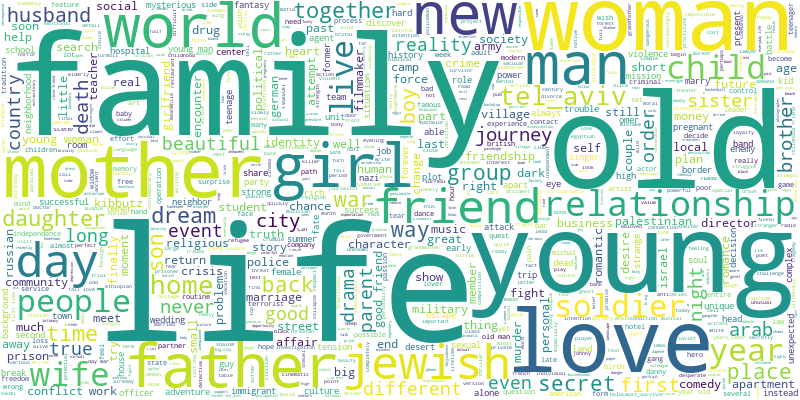

In [175]:
# Create a WordCloud object
wordcloud = WordCloud(
    background_color="white",
    max_words=2000,
    contour_width=3,
    contour_color='steelblue',
    width=800,
    height=400)
# Join the different processed titles together.
long_string = ','.join(ready_data[f'{source}_preprocessed'].to_list())
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

### Topic Modeling - Latent Dirichlet Allocation

Build The Topic Model

In [176]:
def build_LDA_model(ready_data, source, num_topics):
  # Create the Dictionary and Corpus needed for Topic Modeling
  # Create Dictionary
  id2word = corpora.Dictionary(ready_data[f'{source}_lemmatized'].tolist())
  # Create Corpus
  texts = ready_data[f'{source}_lemmatized'].tolist()
  # Term Document Frequency
  corpus = [id2word.doc2bow(text) for text in texts]
  del texts
  
  # Build LDA model
  lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=num_topics, 
                                               random_state=7,
                                               eval_every=10,
                                               chunksize=100,
                                               passes=10,
                                               per_word_topics=True,
                                               workers=8)   
  return lda_model, corpus, id2word

def allocate_topics(i, lda_model):
  return lda_model[corpus[i]][0]

def get_max_probability_topic(x, num_topics):
  return max(x, key=itemgetter(1))[0]

In [177]:
num_topics = 10
lda_model, corpus, id2word = build_LDA_model(ready_data, source=source, num_topics=num_topics)
lda_model.save('lda_model')

lda_model.print_topics()

[(0,
  '0.016*"life" + 0.009*"year" + 0.008*"mother" + 0.008*"day" + 0.008*"time" + 0.008*"night" + 0.007*"world" + 0.007*"together" + 0.007*"reality" + 0.006*"father"'),
 (1,
  '0.009*"family" + 0.008*"people" + 0.008*"different" + 0.006*"situation" + 0.006*"world" + 0.005*"girl" + 0.005*"never" + 0.005*"live" + 0.005*"jewish" + 0.005*"young"'),
 (2,
  '0.013*"old" + 0.011*"family" + 0.009*"life" + 0.008*"love" + 0.006*"father" + 0.006*"soldier" + 0.006*"dream" + 0.006*"reality" + 0.005*"human" + 0.005*"young"'),
 (3,
  '0.019*"young" + 0.015*"family" + 0.009*"couple" + 0.008*"event" + 0.008*"friend" + 0.008*"life" + 0.007*"day" + 0.007*"old" + 0.006*"dream" + 0.006*"war"'),
 (4,
  '0.017*"love" + 0.016*"life" + 0.016*"woman" + 0.012*"young" + 0.009*"girl" + 0.009*"friend" + 0.008*"new" + 0.007*"well" + 0.007*"old" + 0.006*"father"'),
 (5,
  '0.015*"life" + 0.013*"soldier" + 0.013*"man" + 0.010*"woman" + 0.009*"love" + 0.008*"young" + 0.008*"relationship" + 0.008*"year" + 0.007*"girl"

### Evaluation

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -8.308076267759994


Assign Dominant Topic to each record

In [178]:
ready_data['i'] = [i for i in range(len(ready_data))]
ready_data[f'{source}_topic'] = ready_data['i'].swifter.apply(lambda x: allocate_topics(x, lda_model))
ready_data[f'{source}_topic'] = ready_data[f'{source}_topic'].apply(lambda x: get_max_probability_topic(x, num_topics))

del ready_data['i']
ready_data = ready_data.sort_values(by=[f'{source}_topic'])
ready_data

Pandas Apply:   0%|          | 0/1052 [00:00<?, ?it/s]

,Unnamed: 0,IMDb_id,Title,Year,Genre,Synopsis,Synopsis_lemmatized,Synopsis_preprocessed,Synopsis_topic
1051,1468,5566984,Hoze Lech Brach,2008,Drama,Urban Odyssey one night in Tel Aviv.,"[urban, night, tel_aviv]",urban night tel_aviv,0
184,186,103945,Life According to Agfa,1992,Drama,"The film takes place in Tel Aviv, much of it i...","[place, tel_aviv, much, fictitious, local, pub...",place tel_aviv much fictitious local pub barbi...,0
834,995,4495188,Kapo in Jerusalem,2015,"Drama, History",An exploration of the moral and survival dilem...,"[exploration, moral, survival, view, deputy, h...",exploration moral survival view deputy head bl...,0
186,188,5787384,Past Life,2016,Drama,Past Life tracks the daring late 1970s odyssey...,"[past, life, dare, late, sister, introvert, cl...",past life dare late sister introvert classical...,0
833,994,3824034,The Pracht Inn,2014,Drama,An adaptation of Aaron Appelfeld's novel 'Nigh...,"[adaptation, appelfeld, night, night, sixty, g...",adaptation appelfeld night night sixty group h...,0
...,...,...,...,...,...,...,...,...,...
56,57,1366409,Miral,2010,"Drama, History",A drama centered on an orphaned Palestinian gi...,"[drama, palestinian, girl, wake, arab, war, co...",drama palestinian girl wake arab war conflict,9
976,1249,12708228,Primo and Sabbatai,2022,"Comedy, Drama","Primo is obsessed with Sabbatai Zevi, the fals...","[life, sequence, religious, sexual, scandal, l...",life sequence religious sexual scandal lose so...,9
974,1245,1311654,Halakeh,2008,Drama,This is the story of a journey made by a young...,"[journey, young, religious, family, old, son, ...",journey young religious family old son yoni ba...,9
443,462,2164718,Rock the Casbah,2012,"Action, Drama, History",The year is 1989. In an era of Palestinian dem...,"[era, palestinian, demand, independence, send,...",era palestinian demand independence send young...,9


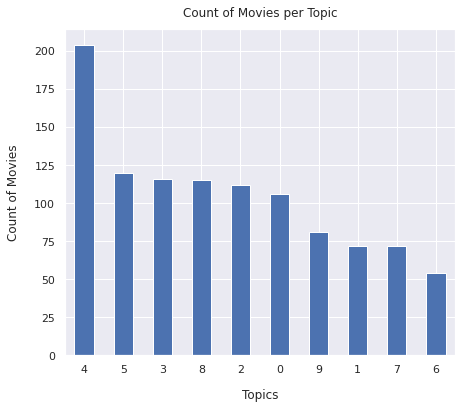

In [179]:
ready_data[f'{source}_topic'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0);
plt.xlabel("Topics", labelpad=14)
plt.ylabel("Count of Movies", labelpad=14)
plt.title("Count of Movies per Topic", y=1.02);

movies age AVG per 

In [203]:
# ready_data.groupby(f'{source}_topic')['Year'].mean()
# ready_data
# test = ready_data[f'{source}_topic']['Year']
test = ready_data.copy()
test = test.drop(columns=['IMDb_id', 'Title', 'Synopsis', 'Synopsis_lemmatized', 'Synopsis_preprocessed', 'Genre', 'Unnamed: 0'])
test.groupby(f'{source}_topic')['Year'].mean()

# test.groupby(by = f'{source}_topic').mean().plot(kind='pie', y='Year', subplots=True)
# test.groupby(f'{source}_topic')['Year'].mean().hist()


Synopsis_topic
0    2005.716981
1    2001.000000
2    2004.178571
3    2001.732759
4    2001.205882
5    2000.525000
6    2002.537037
7    2001.375000
8    2003.330435
9    2003.518519
Name: Year, dtype: float64

Genre counts per topic

In [207]:
test2 = ready_data.copy()
test2 = test2.drop(columns=['IMDb_id', 'Title', 'Synopsis', 'Synopsis_lemmatized', 'Synopsis_preprocessed', 'Year', 'Unnamed: 0'])
test2.groupby(f'{source}_topic')['Genre'].value_counts()

# ready_data.groupby('Genre').sum().plot.pie(y='Genre', figsize=(15,5))



Synopsis_topic  Genre                   
0               Drama                       60
                Comedy, Drama                6
                Drama, Romance               5
                Comedy, Drama, Romance       3
                Drama, History               3
                                            ..
9               Drama, Sport                 1
                Drama, Thriller              1
                Drama, Thriller, War         1
                Horror, Sci-Fi, Thriller     1
                Western                      1
Name: Genre, Length: 337, dtype: int64

### Visualize Topics


Word Clouds of Top N Keywords in Each Topic

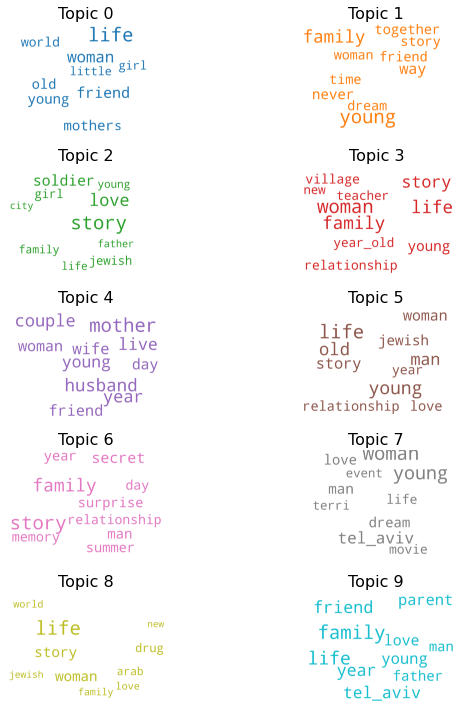

In [ ]:
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(int(num_topics/2), 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.040689 -0.026510       1        1  14.579791
1     -0.011265  0.008211       2        1  14.143182
0     -0.087787 -0.109187       3        1  13.991789
2      0.029259  0.052525       4        1  11.992527
9     -0.122558  0.087207       5        1  10.299432
8      0.094146 -0.094881       6        1   8.613536
4     -0.043333 -0.041567       7        1   7.809738
3      0.086377  0.009706       8        1   7.567430
7      0.029091  0.073562       9        1   6.065793
6      0.066758  0.040935      10        1   4.936784, topic_info=         Term        Freq       Total Category  logprob  loglift
58       life  201.000000  201.000000  Default  30.0000  30.0000
108     story  162.000000  162.000000  Default  29.0000  29.0000
430   soldier   57.000000   57.000000  Default  28.0000  28.0000
11      woman  152.000000  152.000000  Default  27.0000  27.0000
32     family  138.000000  138.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
539    sister    3.291391   28.225871  Topic10  -5.6477   0.8595
183      love    3.666699  121.064314  Topic10  -5.5397  -0.4886
313    future    2.973455   16.607837  Topic10  -5.7493   1.2883
17       girl    3.315779   83.098380  Topic10  -5.6403  -0.2129
1481      end    3.023575   26.406472  Topic10  -5.7326   0.8413

[760 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
4445     10  0.853189  abomination
3443      2  0.238996       abroad
3443      7  0.716988       abroad
3470      6  0.638279        abuse
2306      3  0.651840     accident
...     ...       ...          ...
12        8  0.072221        young
12        9  0.084258        young
12       10  0.030092        young
4314      2  0.936056       zodiac
2216      6  0.725995        zohar

[1552 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 1, 3, 10, 9, 5, 4, 8, 7])

Word Counts of Topic Keywords

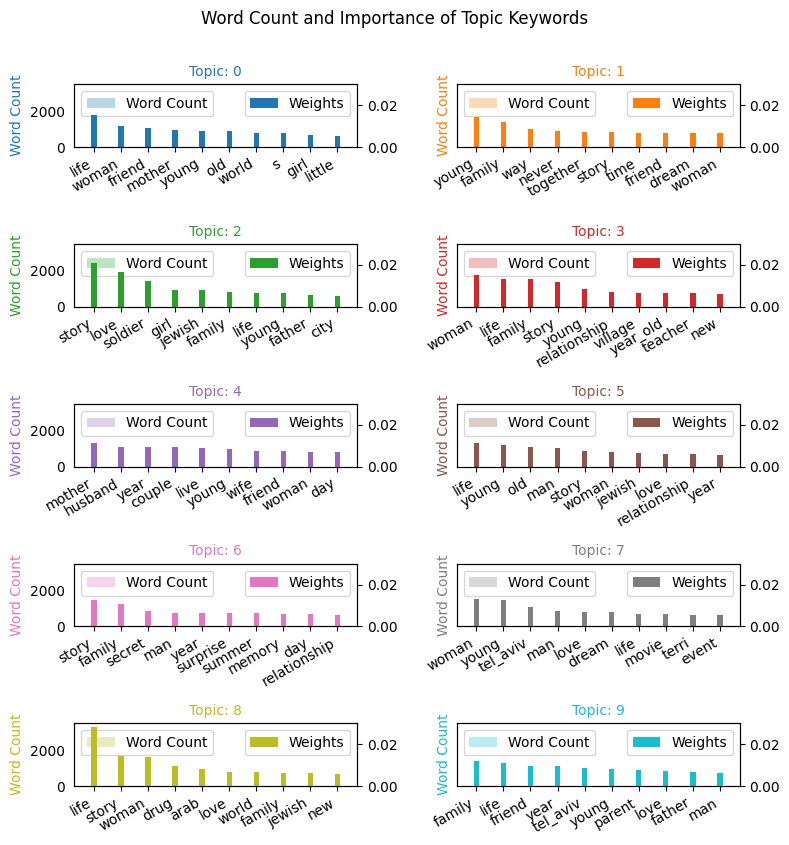

In [ ]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in ready_data for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(int(num_topics/2), 2, figsize=(8,8), sharey=True, dpi=100)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=10)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=12, y=1.05)    
plt.show()